Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/dev/Turing/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Use Turing mcmc

In [7]:
chn = sample(model, NUTS(2000, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 1.6
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/support/hmc_core.jl:235
┌ Warning: 30.233553739684915 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 7.889099062323837 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 10.523286147870516 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Warning: 5.229921113851469 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/dev/Turing/src/inference/adapt/stepsize.jl:96
┌ Info:  Adapted ϵ = 0.8841413789991208, std = [1.

Look at the generated draws (in chn)

In [8]:
describe(chn)

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

Empirical Posterior Estimates:
              Mean         SD       Naive SE       MCSE         ESS   
  lf_num  0.0000000000 0.00000000 0.0000000000 0.0000000000        NaN
 elapsed  0.0025446278 0.07871639 0.0017601519 0.0022423815 1232.28545
 epsilon  0.9187382843 0.33682223 0.0075315740 0.0238167925  200.00228
   theta  0.6357515425 0.13463105 0.0030104419 0.0045121098  890.28933
      lp -3.2661739520 0.70105076 0.0156759715 0.0214981117 1063.40402
eval_num  7.3710000000 3.57613666 0.0799648466 0.1193444815  897.89081
  lf_eps  0.9187382843 0.33682223 0.0075315740 0.0238167925  200.00228

Quantiles:
              2.5%          25.0%        50.0%          75.0%         97.5%    
  lf_num  0.00000000000  0.000000000  0.0000000000  0.00000000000  0.0000000000
 elapsed  0.00012594938  0.000133993  0.0003250385  0.00034713975  0.0005565535
 epsilon  0.55168448639  0.884141379  0.8841413790  0.88414137900  1.5

Look at the mean and sd

In [9]:
println("\ntheta = $(mean_and_std(chn[:theta][201:2000]))\n")


theta = (0.6337201263647877, 0.1355659188063515)



Fix the inclusion of adaptation samples

In [10]:
chn2 = MCMCChain.Chains(chn.value[201:2000,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Union{Missing, Float64}[0.0 0.024906 … 10.0 0.884141; 0.0 0.0104409 … 4.0 0.884141; … ; 0.0 0.000348915 … 10.0 0.884141; 0.0 0.000169645 … 4.0 0.884141]

Look at the proper draws (in corrected chn2)

In [11]:
describe(chn2)

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Empirical Posterior Estimates:
              Mean                 SD                     Naive SE               MCSE         ESS   
  lf_num  0.0000000000 0.00000000000000000000000 0.000000000000000000000000 0.000000000000       NaN
 elapsed  0.0002961092 0.00077580711605250017755 0.000018285949088450058141 0.000020635112 1413.4936
 epsilon  0.8841413790 0.00000000000000066631893 0.000000000000000015705288 0.000000000000 1800.0000
   theta  0.6337201264 0.13556591880635149305334 0.003195319349525202034384 0.004766491140  808.9161
      lp -3.2699192797 0.69861767637305760558775 0.016466576547339264319225 0.023290428795  899.7548
eval_num  7.2266666667 2.99225607902599843868074 0.070528152150865108804823 0.073493586044 1657.6721
  lf_eps  0.8841413790 0.00000000000000066631893 0.000000000000000015705288 0.000000000000 1800.0000

Quantiles:
              2.5%           25.0%        50.0%         75.0%         

Compute at hpd region

In [12]:
bnds = MCMCChain.hpd(chn2[:, 4, :], alpha=0.06);

analytical calculation

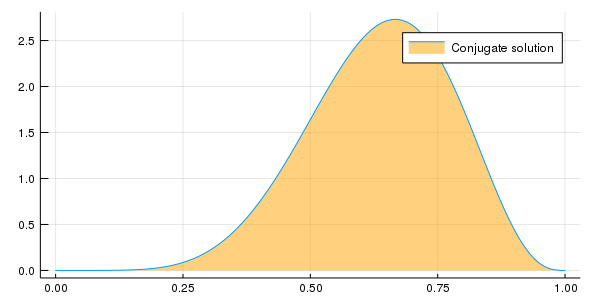

In [13]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

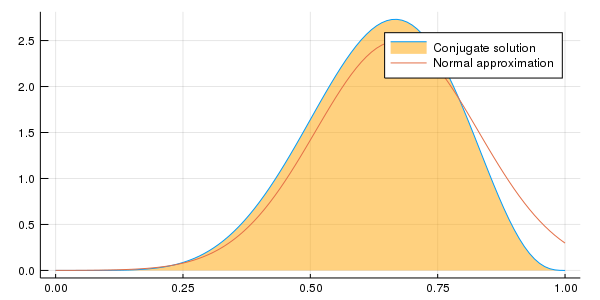

In [14]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

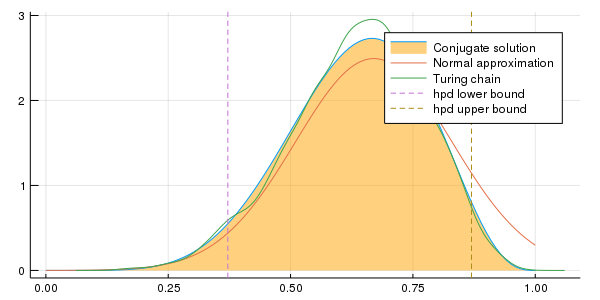

In [15]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 4, 1], lab="Turing chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

Show hpd region

In [16]:
println("hpd bounds = $bnds\n")

hpd bounds =       94% Lower 94% Upper
theta 0.3718323 0.8697195





End of `clip_08t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*